In [1]:
# BrainNetCNN Implementation Version 1.0
# Software by Jeremy Kawahara and Colin J Brown
# Medical Image Analysis Lab, Simon Fraser University, Canada, 2017
# Implements the method described in: dx.doi.org/10.1016/j.neuroimage.2016.09.046

In [2]:
from __future__ import print_function
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%reload_ext autoreload
%autoreload 2
# dir_root_caffe = '/home/jer/projects/caffe/' # Not needed if you have caffe already in path.
# sys.path.insert(0, os.path.join(dir_root_caffe, 'python')) # Needed to import pycaffe.
import caffe

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..'))) # To import ann4brains
from ann4brains.synthetic import injury
from ann4brains.nets import BrainNetCNN
from ann4brains.utils import h5_utils

In [4]:
# Number of outputs.
n_injuries = 2 # NOTE: The synthetic code only works for 2 injuries right now.

# Unique name for the model
net_name = 'E2Nnet_sml'

n_samples = 100  # Number of training/testing samples.
noise_weight = 0.125  # How much to weigh the noise.

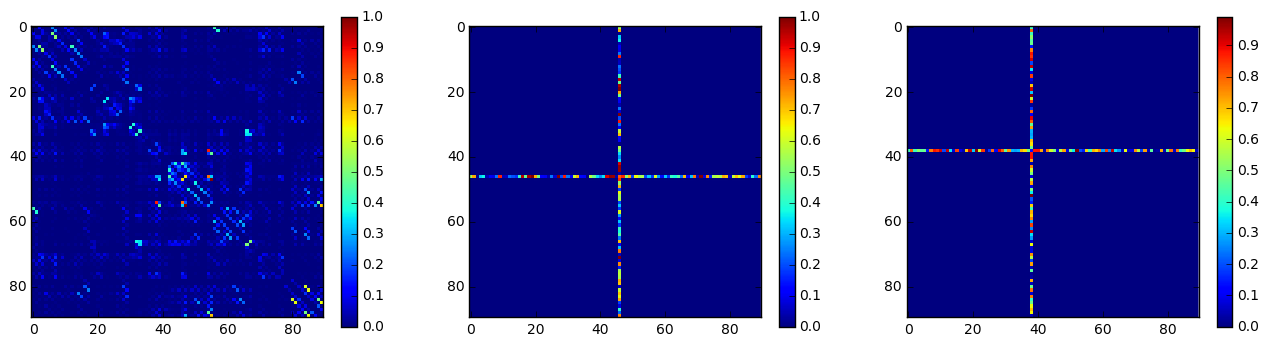

In [6]:
# Load the realistic base connectome and generate the injury signatures.
X_mn = injury.load_base_connectome(os.path.join('data', 'preterm_structural_base.mat'))
np.random.seed(seed=333) # Set the seed so we generate the same signatures.
injury_sigs = injury.generate_injury_signatures(X_mn, n_injuries)

plt.figure(figsize=(16,4))
plt.subplot(1,3,1); plt.imshow(X_mn, interpolation="None"); plt.colorbar();
plt.subplot(1,3,2); plt.imshow(injury_sigs[0], interpolation="None"); plt.colorbar();
plt.subplot(1,3,3); plt.imshow(injury_sigs[1], interpolation="None"); plt.colorbar();

In [7]:
# Dimensions of the spatial input.
d = X_mn.shape[0]

In [8]:
# Generate train, validate, and test data
np.random.seed(seed=333) # To reproduce results.
hdf5_train = injury.generate_injury_data('train', X_mn, injury_sigs, n_samples, noise_weight)
hdf5_test = injury.generate_injury_data('test', X_mn, injury_sigs, n_samples, noise_weight)
hdf5_validate = injury.generate_injury_data('validate', X_mn, injury_sigs, n_samples, noise_weight)

In [9]:
# We specify the architecture like this.
e2n_arch = [['e2n',     {'num_output': 16,  # e2n layer with 64 filters.
                         'kernel_h': d, 'kernel_w': d}],  # Filter sizes are the same dimensions as the spatial inputs.
            ['dropout', {'dropout_ratio': 0.5}],
            ['relu',    {'negative_slope': 0.33}],
            ['fc',      {'num_output': 30}],        # fully connected (also a n2g) layer with 30 filters.
            ['relu',    {'negative_slope': 0.33}],
            ['out',     {'num_output': n_injuries}]]  # output layer with num_outs nodes as outputs.

# Create BrainNetCNN model
E2Nnet_sml = BrainNetCNN(net_name, e2n_arch, hdf5_train, hdf5_validate)

# Overwrite some default model parameters for this shorter training example.
E2Nnet_sml.pars['max_iter'] = 1000
E2Nnet_sml.pars['snapshot'] = 50
E2Nnet_sml.pars['test_interval'] = 10

In [10]:
# Train (optimize) the network.
E2Nnet_sml.fit(set_mode='cpu') # or set_mode='gpu'

In [11]:
# Load the test data.
test_data = h5_utils.read_h5(hdf5_test, ['data', 'label'])

In [12]:
# Predict labels of test data
preds = E2Nnet_sml.predict(test_data['data'])

In [13]:
# Print prediction results
print('Prediction Results')
BrainNetCNN.print_results(preds, test_data['label'])

Prediction Results
rho => mae: 0.2149, corr: 0.5753, p-val: 0.0000
rho => mae: 0.2264, corr: 0.4868, p-val: 0.0000
1.06205
